In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Loading data

In [205]:
# UC admissions data by ethnicity
years = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

ethnicity = {}
gender = {}
gpa = {}
for year in years:
    ethnicity[f'{year}'] = pd.read_csv(f'ethnicity/{year}_ethn.csv', encoding='utf-16le', delimiter='\t', on_bad_lines='skip')
    gender[f'{year}'] = pd.read_csv(f'gender/{year}_gender.csv', encoding='utf-16le', delimiter='\t', on_bad_lines='skip')
    gpa[f'{year}'] = pd.read_csv(f'GPA/{year}_gpa.csv', index_col=0)

# specifically for 2017 ethnicity data, it uses utf-8 for some reason
ethnicity['2017'] = pd.read_csv(f'ethnicity/2017_ethn.csv', encoding='utf-8')

# median income by household at city level from census
census = pd.read_csv('https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/Census/ACSST1Y2022.S1903-2024-05-27T042652.csv', index_col = 0)


#scraped park access data
parks = pd.read_csv("https://raw.githubusercontent.com/wanning-lu/MATH-189-Final-Project/master/park_access/parks_data.csv", encoding='utf-8')
#Clean
parks['City'] = parks['City'].str.replace(',California', '') 

### Filtering income data to contain only Californian cities

In [206]:
# using regex
pattern = r'California'  # this pattern matches any column name containing 'Measure'
# use filter to select columns that match the regex pattern
matching_columns = census.filter(regex=pattern).columns
# drop columns that do not match the pattern
census_filtered = census[matching_columns]

# repeat this so we narrow the data down to median income of californian cities
estimates = r'Estimate'
matching_columns2 = census_filtered.filter(regex=estimates).columns
census_income = census_filtered[matching_columns2]

Inc = r'Median income'
matching_columns3 = census_income.filter(regex=Inc).columns
california_income = census_filtered[matching_columns3]

# clean up column names
column_mapping = {col: col.split(',')[0] for col in california_income.columns}

# rename columns
california_income = california_income.rename(columns=column_mapping)

# clean up column names some more
def remove_last_word(s):
    return ' '.join(s.split()[:-1])

column_mapping = {col: remove_last_word(col) for col in california_income.columns}

california_income = california_income.rename(columns=column_mapping)

# lets get the cities as rows so we can merge it a bit easier
california_income = california_income.T

# lets bring the cities into a col so easier to merge
california_income = california_income.reset_index(drop=False)

# rename column
california_income = california_income.rename(columns={'index': 'City', '\xa0\xa0\xa0\xa0Households': 'Household Income'})

# lets keep only city and income data
california_income = california_income[['City', 'Household Income']]
# lets make income into ints
california_income['Household Income'] = california_income['Household Income'].str.replace(',', '').astype(int)
california_income.head()

Label (Grouping)                       City  Household Income
0                 California!!Median income             91551
1                                   Alameda            131116
2                                  Alhambra             72406
3                                   Anaheim             85133
4                                   Antioch            100178

### NaN values in our UC and Park access data

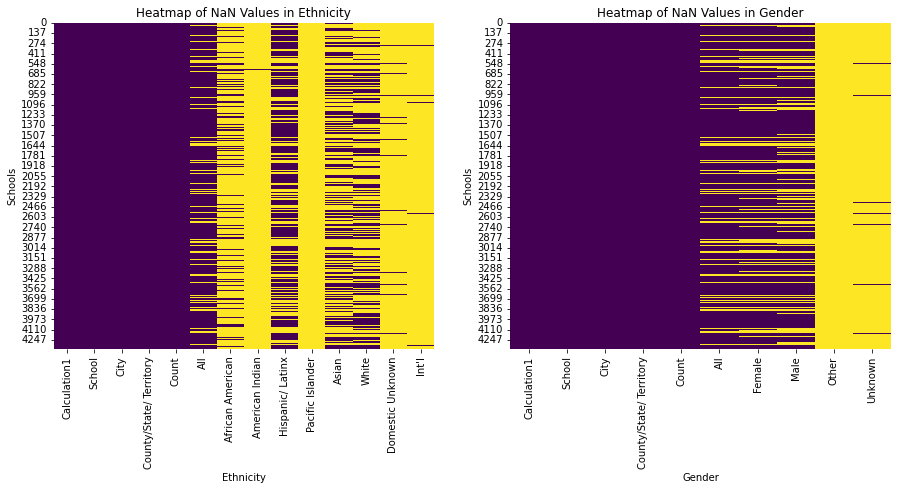

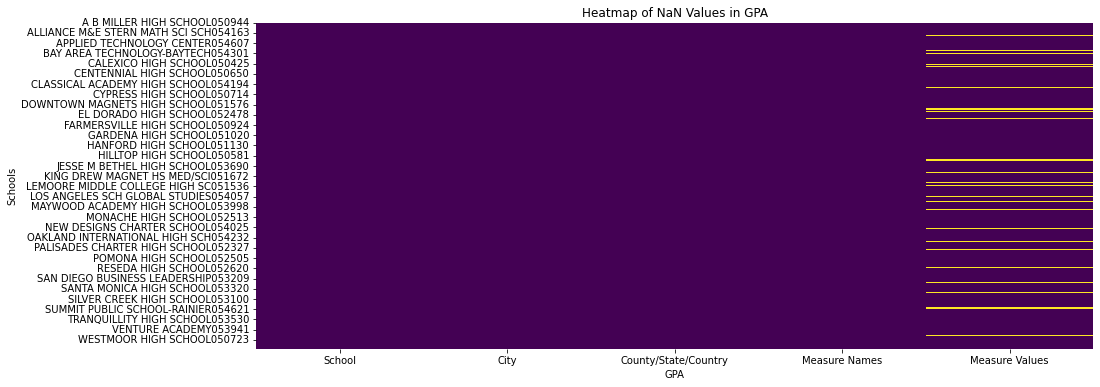

<Figure size 720x432 with 0 Axes>

In [207]:
#lets see how many Na values we have in our data

nan_df_ethn = ethnicity['2016'].isna()
nan_df_gender = gender['2016'].isna()
nan_df_gpa = gpa['2016'].isna()

# Create a figure with subplots 
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig2, ax2 = plt.subplots(1, 1, figsize=(15, 6))

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(nan_df_ethn, cmap='viridis', cbar=False, ax=ax[0])
sns.heatmap(nan_df_gender, cmap='viridis', cbar=False, ax=ax[1])
sns.heatmap(nan_df_gpa, cmap='viridis', cbar=False, ax=ax2)


# Add labels and title
ax[0].set_xlabel('Ethnicity')
ax[0].set_ylabel('Schools')
ax[0].set_title('Heatmap of NaN Values in Ethnicity')

ax[1].set_xlabel('Gender')
ax[1].set_ylabel('Schools')
ax[1].set_title('Heatmap of NaN Values in Gender')

ax2.set_xlabel('GPA')
ax2.set_ylabel('Schools')
ax2.set_title('Heatmap of NaN Values in GPA')

# Show the plot
plt.show()

The documentation say for any category with < 3 students, it is entered as null. We will have decide how we will deal with this.

### Merge DataFrames across the categories

In [208]:
merged_years = {}
for year in years:
    merged_years[f'{year}'] = pd.merge(ethnicity[f'{year}'], california_income, on='City', how='inner')
    merged_years[f'{year}'] = pd.merge(merged_years[f'{year}'], gender[f'{year}'], on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')
    merged_years[f'{year}'] = pd.merge(merged_years[f'{year}'], gpa[f'{year}'], on=['City','School'], how='inner')
    merged_years[f'{year}'] = pd.merge(merged_years[f'{year}'], parks, on='City', how='inner')  # Merge with parks directly using the 'City' column
    merged_years[f'{year}'] = merged_years[f'{year}'].set_index('Count')


# merged_df_16 = pd.merge(ethn_16, california_income, on='City', how='inner')
# merged_df_16 = pd.merge(merged_df_16, gen_16, on=['Calculation1', 'School', 'County/State/ Territory','Count','All', 'City'], how='inner')
# merged_df_16 = pd.merge(merged_df_16, gpa_16, on=['City','School'], how='inner')
# merged_df_16 = merged_df_16.set_index('Count')

### Clean data further

In [209]:
# this adds "app" and "adm" as a column and resets the index to 0-n
#changed this cell I recieved this error: TypeError: reset_index() got an unexpected keyword argument 'name'
for year in years:
    merged_years[year]['status'] = merged_years[year].index
    merged_years[year] = merged_years[year].reset_index(drop=True)

In [210]:
for year in years:
    # remove 'enrolled' rows
    merged_years[year] = merged_years[year].loc[merged_years[year]['status'].isin(['App', 'Adm'])]
    # keep only one gpa - the admits' average gpas
    merged_years[year] = merged_years[year].loc[merged_years[year]['Measure Names'].isin(['Adm GPA'])]

In [211]:
for year in years:
    # preprocess gpa column so that it's weighted
    merged_years[year]['Measure Values'] = merged_years[year].groupby(merged_years[year]['status'])['Measure Values'].transform(lambda x: x * merged_years[year]['All'])
    # now begin merging the rows based on city by gender, ethnicity, and gpa
    merged_years[year] = merged_years[year].groupby(['City', 'status', 'Household Income'])[['All', 'African American', 'American Indian', 'Hispanic/ Latinx', 
                                                                        'Pacific Islander', 'Asian', 'White', 'Domestic Unknown', 'Int\'l', 
                                                                        'Female', 'Male', 'Other', 'Unknown', 'Measure Values']].sum()
    merged_years[year] = merged_years[year].reset_index()

In [212]:
# now fix the GPA!
for year in years:
    merged_years[year]['Measure Values'] = merged_years[year].groupby(['City', 'status'])['Measure Values'].transform(lambda x: x / merged_years[year]['All'])

### Exploratory Data Analysis

In [213]:
# Combining the datasets from 2016 to 2023
dataframes_list = []

for year in years:
    dataframes_list.append(merged_years[year])

combined_years = pd.concat(dataframes_list, ignore_index=True)

combined_years

City status  Household Income    All  African American  \
0         Alameda    Adm            131116  220.0              10.0   
1         Alameda    App            131116  292.0              19.0   
2        Alhambra    Adm             72406  284.0               0.0   
3        Alhambra    App             72406  381.0               0.0   
4         Anaheim    Adm             85133  447.0               4.0   
...           ...    ...               ...    ...               ...   
1969     Whittier    App             91457  546.0              12.0   
1970  Yorba Linda    Adm            151534  102.0               0.0   
1971  Yorba Linda    App            151534  157.0               0.0   
1972    Yuba City    Adm             59588   96.0               0.0   
1973    Yuba City    App             59588  138.0               0.0   

      American Indian  Hispanic/ Latinx  Pacific Islander  Asian  White  \
0                 0.0               8.0               0.0  140.0   39.0   
1                 0.0              14.0               0.0  174.0   52.0   
2                 0.0              15.0               0.0  255.0    0.0   
3                 0.0              44.0               0.0  317.0    0.0   
4                 0.0             213.0               0.0  141.0   62.0   
...               ...               ...               ...    ...    ...   
1969              0.0             464.0               0.0   25.0   29.0   
1970              0.0              15.0               0.0   50.0   26.0   
1971              0.0              24.0               0.0   71.0   47.0   
1972              0.0              24.0               0.0   47.0   17.0   
1973              0.0              39.0               0.0   63.0   25.0   

      Domestic Unknown  Int'l  Female   Male  Other  Unknown  Measure Values  
0                  3.0    0.0   120.0   98.0    0.0      0.0        3.949851  
1                  5.0    0.0   158.0  132.0    0.0      0.0        3.950483  
2                  0.0    0.0   151.0  123.0    0.0      8.0        3.743325  
3                  0.0    0.0   203.0  164.0    0.0     10.0        3.743359  
4                  4.0    0.0   259.0  179.0    0.0      0.0        3.829754  
...                ...    ...     ...    ...    ...      ...             ...  
1969               0.0    0.0   346.0  184.0    0.0      0.0        4.002486  
1970               7.0    0.0    56.0   39.0    0.0      0.0        4.002059  
1971              10.0    0.0    90.0   58.0    0.0      0.0        4.002059  
1972               0.0    0.0    59.0   36.0    0.0      0.0        4.003958  
1973               0.0    0.0    84.0   51.0    0.0      0.0        4.001924  

[1974 rows x 17 columns]

#### How do acceptances differ between male and females?


Percentage of Male Applicants Admitted: 64.54766063826449 %
Percentage of Female Applicants Admitted: 67.60385100771562 %


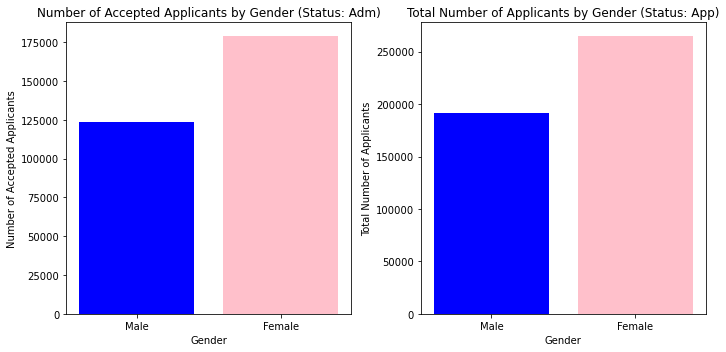

In [214]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame for rows where status is 'Adm'
df_adm = combined_years[combined_years['status'] == 'Adm']
# Filter the DataFrame for rows where status is 'App'
df_app = combined_years[combined_years['status'] == 'App']

# Sum up the 'All' column separately for male and female applicants where status is 'Adm'
sum_male_adm = df_adm['Male'].sum()
sum_female_adm = df_adm['Female'].sum()

# Sum up the 'All' column separately for male and female applicants where status is 'App'
sum_male_app = df_app['Male'].sum()
sum_female_app = df_app['Female'].sum()

# Calculate the percentage of applicants admitted for each gender
percentage_male = (sum_male_adm / sum_male_app) * 100
percentage_female = (sum_female_adm / sum_female_app) * 100

# Print the percentages
print("Percentage of Male Applicants Admitted:", percentage_male, "%")
print("Percentage of Female Applicants Admitted:", percentage_female, "%")

# Plotting
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(['Male', 'Female'], [sum_male_adm, sum_female_adm], color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Number of Accepted Applicants')
plt.title('Number of Accepted Applicants by Gender (Status: Adm)')

plt.subplot(1, 2, 2)
plt.bar(['Male', 'Female'], [sum_male_app, sum_female_app], color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Total Number of Applicants')
plt.title('Total Number of Applicants by Gender (Status: App)')

plt.tight_layout()
plt.show()


#### How do acceptances differ between Ethnicities?


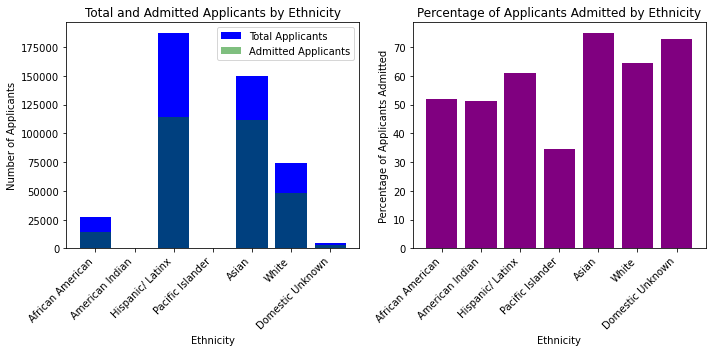

In [215]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame for rows where status is 'Adm'
df_adm = combined_years[combined_years['status'] == 'Adm']
# Filter the DataFrame for rows where status is 'App'
df_app = combined_years[combined_years['status'] == 'App']

# List of ethnicity groups
ethnicity_groups = ['African American', 'American Indian', 'Hispanic/ Latinx', 'Pacific Islander', 'Asian', 'White', 'Domestic Unknown']

# Initialize dictionaries to store total applicants and total admitted applicants for each ethnicity
total_applicants_ethnicity = {}
total_admitted_ethnicity = {}

# Calculate total applicants and total admitted applicants for each ethnicity
for ethnicity in ethnicity_groups:
    total_applicants_ethnicity[ethnicity] = df_app[ethnicity].sum()
    total_admitted_ethnicity[ethnicity] = df_adm[ethnicity].sum()

# Calculate the percentage of applicants admitted for each ethnicity
percentage_admitted_ethnicity = {}
for ethnicity in ethnicity_groups:
    if total_applicants_ethnicity[ethnicity] != 0:
        percentage_admitted_ethnicity[ethnicity] = (total_admitted_ethnicity[ethnicity] / total_applicants_ethnicity[ethnicity]) * 100
    else:
        percentage_admitted_ethnicity[ethnicity] = 0

# Plotting
plt.figure(figsize=(10, 5))

# Plot total number of applicants and admitted applicants for each ethnicity
plt.subplot(1, 2, 1)
plt.bar(ethnicity_groups, [total_applicants_ethnicity[ethnicity] for ethnicity in ethnicity_groups], label='Total Applicants', color='blue')
plt.bar(ethnicity_groups, [total_admitted_ethnicity[ethnicity] for ethnicity in ethnicity_groups], label='Admitted Applicants', color='green', alpha=0.5)
plt.xlabel('Ethnicity')
plt.ylabel('Number of Applicants')
plt.title('Total and Admitted Applicants by Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Plot percentage of applicants admitted for each ethnicity
plt.subplot(1, 2, 2)
plt.bar(ethnicity_groups, [percentage_admitted_ethnicity[ethnicity] for ethnicity in ethnicity_groups], color='purple')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of Applicants Admitted')
plt.title('Percentage of Applicants Admitted by Ethnicity')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


#### How do acceptances differ by median income of the city?


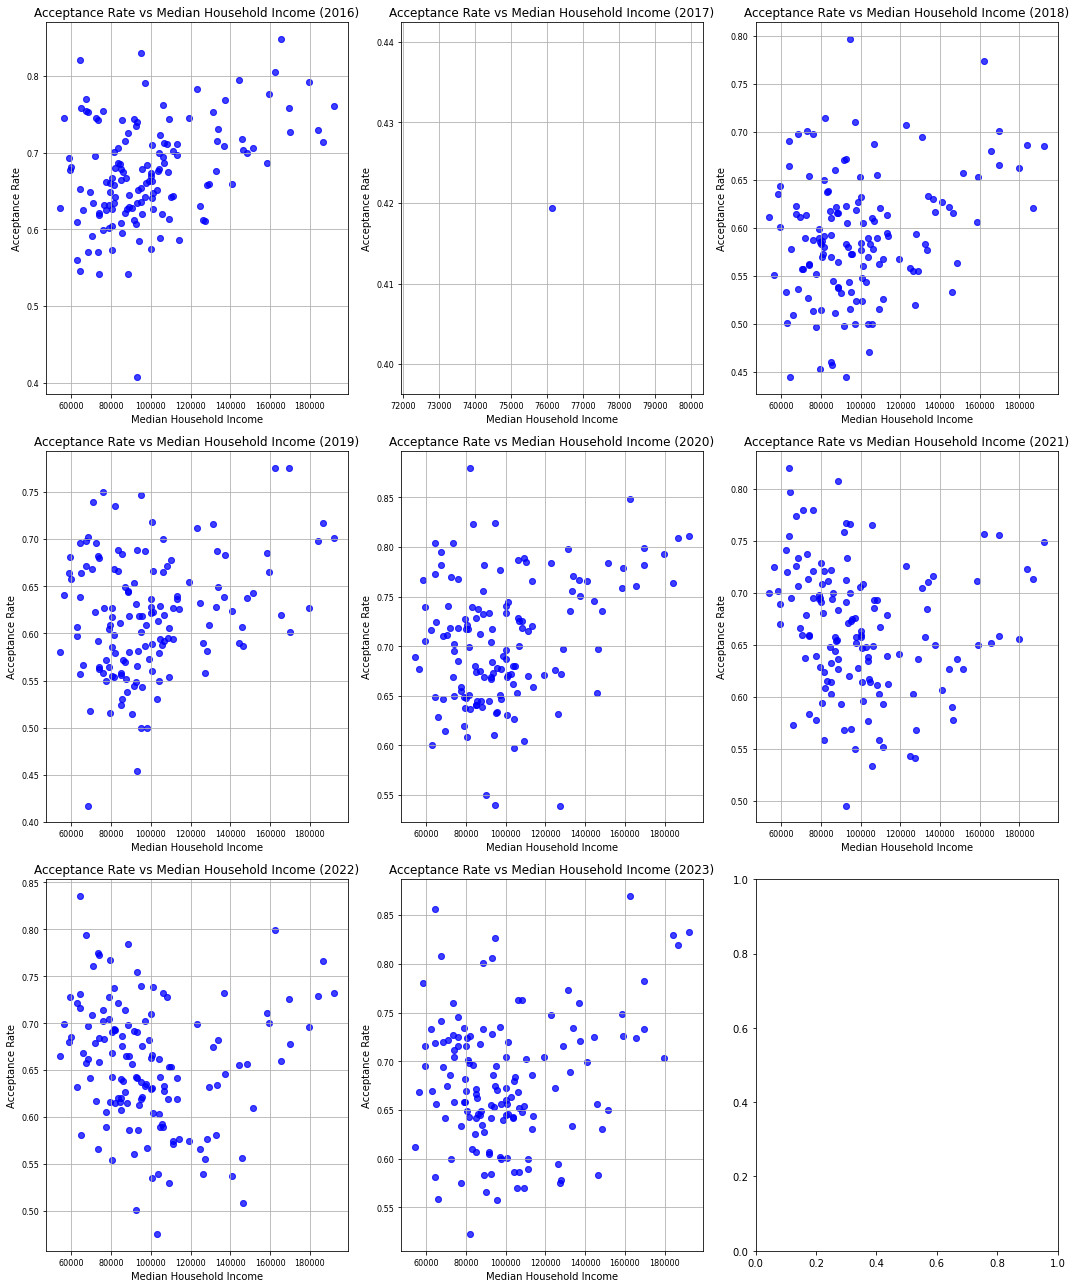

In [262]:
import matplotlib.pyplot as plt

# Define years
years = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

# Create subplots for the grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 18))

# Loop through each year
for i, year in enumerate(years):
    # Calculate row and column index for subplot
    row = i // 3
    col = i % 3
    
    # Group by city and calculate acceptance rate
    grouped = merged_years[year].groupby('City').apply(lambda x: 
        x[x['status'] == 'Adm']['All'].iloc[0] / x[x['status'] == 'App']['All'].iloc[0]
        if ('Adm' in x['status'].values) and ('App' in x['status'].values)
        else None)
    
    # Rename the column and join with the original DataFrame
    merged_years[year]['Acceptance Rate'] = merged_years[year]['City'].map(grouped)

    # Plot scatter plot
    ax = axes[row, col]
    ax.scatter(merged_years[year]['Household Income'], merged_years[year]['Acceptance Rate'], color='blue', alpha=0.5)
    ax.set_xlabel('Median Household Income', fontsize=10)  # Adjust font size
    ax.set_ylabel('Acceptance Rate', fontsize=10)           # Adjust font size
    ax.set_title(f'Acceptance Rate vs Median Household Income ({year})', fontsize=12)  # Adjust font size
    ax.tick_params(axis='both', which='major', labelsize=8)  # Adjust tick label font size
    ax.grid(True)


# Adjust layout
plt.tight_layout()
plt.show()


#### How does GPA vary between median household income?


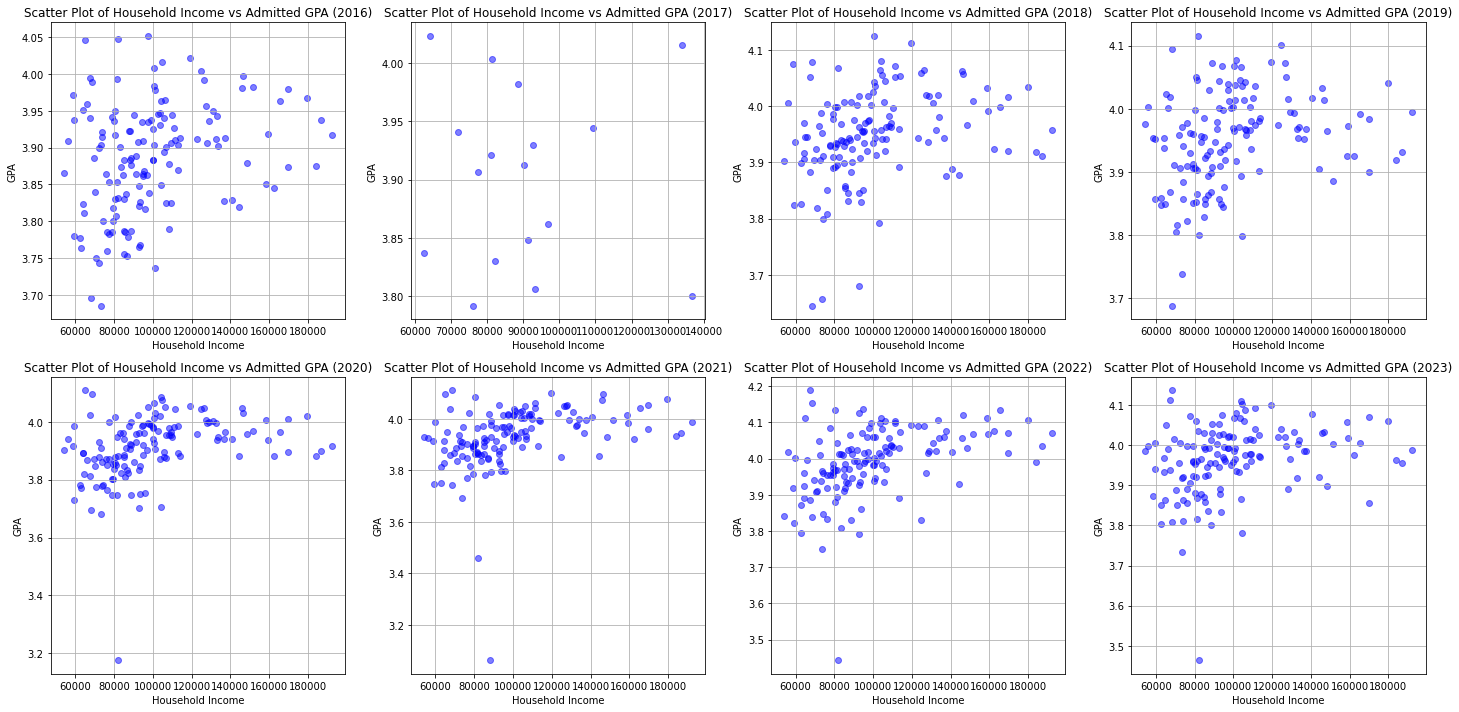

In [257]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Iterate over the years and plot scatter plots
for i, year in enumerate(range(2016, 2024)):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    
    # Check if data is available for the current year
    if str(year) in adm_data_years:
        ax.scatter(adm_data_years[str(year)]['Household Income'], adm_data_years[str(year)]['Measure Values'], color='blue', alpha=0.5)
        ax.set_title(f'Scatter Plot of Household Income vs Admitted GPA ({year})')
        ax.set_xlabel('Household Income')
        ax.set_ylabel('GPA')
        ax.grid(True)
    else:
        ax.axis('off')  # Hide the empty subplot if data is not available

# Adjust layout
plt.tight_layout()
plt.show()


### How does park access vary by income level? (This will be important to verify our instrument is valid later.)

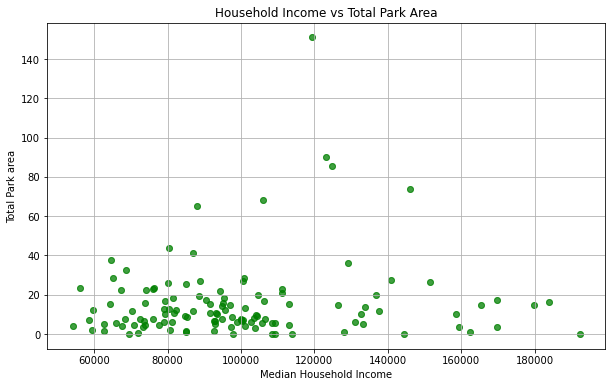

In [263]:
park_income = pd.merge(merged_years['2016'], parks, on='City', how='inner')




# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(park_income['Household Income'], park_income['Parks Area'], color='green', alpha=0.5)
plt.xlabel('Median Household Income')
plt.ylabel('Total Park area')
plt.title('Household Income vs Total Park Area')
plt.grid(True)
plt.show()